<a href="https://colab.research.google.com/github/rakshith-git/ML-Malaria-cell-detector/blob/main/Malaria_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input

In [2]:
dataset,dataset_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete24E0J3/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
train,test,val=0.8,0.1,0.1
def splits(dataset,train,val,test):
  dataset_size=len(dataset)
  train_dataset=dataset.take(int(train*dataset_size))
  val_dataset=dataset.skip(int(train*dataset_size)).take(int(val*dataset_size))
  test_dataset=dataset.skip(int(train*dataset_size)).skip(int(val*dataset_size)).take(int(test*dataset_size))
  return train_dataset,val_dataset,test_dataset

In [4]:
train_ds,val_ds,test_ds=splits(dataset[0],train,val,test )

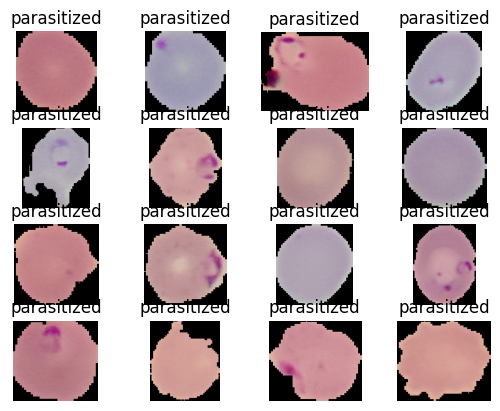

In [5]:
for i ,(image,label) in enumerate(train_ds.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(0))
  plt.axis('off')

In [6]:

import numpy as np
img_size=224
def resizing(image,label):
  return tf.image.resize(image,(img_size,img_size))/255.0,label
train_ds=train_ds.map(resizing)
val_ds=val_ds.map(resizing)
test_ds=test_ds.map(resizing)
batch_size=32
train_ds=train_ds.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds=test_ds.batch(1)

In [7]:
model=tf.keras.Sequential([InputLayer(input_shape=(img_size,img_size,3))
                            ,Conv2D(
                                  filters=6,
                                  kernel_size=3,
                                  strides=1,
                                  padding='valid',
                                  activation="relu"),
                          BatchNormalization(),
                           MaxPool2D(
                                  pool_size=2,
                                  strides=2,
                                  padding='valid',),
                           Conv2D(
                                  filters=16,
                                  kernel_size=3,
                                  strides=(1, 1),
                                  padding='valid',
                                  activation="relu"),
                           BatchNormalization(),
                           MaxPool2D(
                                  pool_size=2,
                                  strides=2,
                                  padding='valid',),
                           Flatten(),
                           Dense(100,activation="relu"),
                           BatchNormalization(),
                           Dense(10,activation="relu"),
                           BatchNormalization(),
                           Dense(1,activation="sigmoid"),
                           ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [8]:
model.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics='accuracy')

In [9]:
history=model.fit(train_ds,validation_data=val_ds, epochs=25,verbose=1)

Epoch 1/25
689/689 [==============================] - 93s 110ms/step - loss: 0.5272 - accuracy: 0.7307 - val_loss: 1.8107 - val_accuracy: 0.6392
Epoch 2/25
689/689 [==============================] - 57s 82ms/step - loss: 0.2404 - accuracy: 0.9160 - val_loss: 0.3141 - val_accuracy: 0.9270
Epoch 3/25
689/689 [==============================] - 43s 62ms/step - loss: 0.2042 - accuracy: 0.9313 - val_loss: 0.8592 - val_accuracy: 0.5241
Epoch 4/25
689/689 [==============================] - 49s 71ms/step - loss: 0.1852 - accuracy: 0.9370 - val_loss: 2.3890 - val_accuracy: 0.5808
Epoch 5/25
689/689 [==============================] - 51s 73ms/step - loss: 0.1723 - accuracy: 0.9406 - val_loss: 0.1679 - val_accuracy: 0.9521
Epoch 6/25
689/689 [==============================] - 49s 70ms/step - loss: 0.1713 - accuracy: 0.9426 - val_loss: 0.7795 - val_accuracy: 0.9172
Epoch 7/25
689/689 [==============================] - 43s 62ms/step - loss: 0.1650 - accuracy: 0.9457 - val_loss: 0.5524 - val_accuracy

In [10]:
test_ds


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
model.evaluate(test_ds)

2755/2755 [==============================] - 22s 4ms/step - loss: 0.5464 - accuracy: 0.9270


[0.5464462041854858, 0.92704176902771]

In [12]:
model.predict(test_ds.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.9312736

In [13]:
def detector(x):
  if x>0.5:
    return('p')
  else:
    return('n')

In [14]:
detector(model.predict(test_ds.take(1))[0][0])


1/1 [==============================] - 11s 11s/step


'p'

1/1 [==============================] - 11s 11s/step


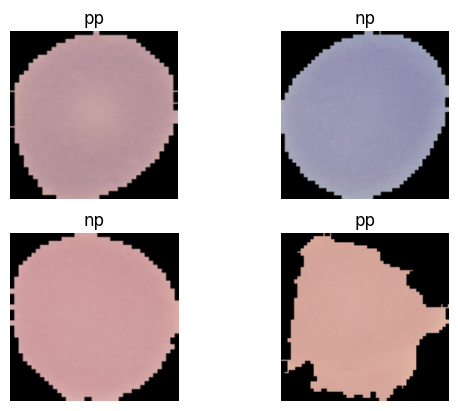

In [15]:
for i ,(image,label) in enumerate(test_ds.take(4)):
  ax=plt.subplot(2,2,i+1)
  plt.imshow(image[0])
  plt.title(str(detector(model.predict(test_ds.take(1))[0][0]))+str(detector(label.numpy()[0:5])))
  plt.axis('off')

In [16]:
 #lenet_model.save("savedMalariaModel")

In [17]:
#new_model=tf.keras.models.load_model("savedMalariaModel")

In [18]:
#new_model.evaluate(test_ds)

In [19]:
# func_input=Input(shape=(img_size,img_size,3),name='Input')
# x=Flatten()(x)
# x=Dense(100, activation="relu")(x)
# x=BatchNormalization()(x)
# x=Dense(10, activation="relu")(x)
# x=BatchNormalization()(x)
# func_output=Dense(1, activation="sigmoid")(x)
# lenet_model=Model(func_input,func_output,name="lenet_Model")
# lenet_model.summary()


In [ ]:
# func_input=Input(shape=(img_size,img_size,3),name='Input')
# x=Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu")(func_input)
# x=BatchNormalization()(x)
# x=MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
# x=Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation="relu")(x)
# x=BatchNormalization()(x)
# x=MaxPool2D(pool_size=2, strides=2, padding='valid')(x)


In [ ]:
# lenet_model.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics='accuracy')

In [20]:
# history=lenet_model.fit(train_ds,validation_data=val_ds, epochs=20,verbose=1)